In [ ]:
#importing the libraries
import torch 
import torch.nn as nn
from torchvision import datasets,models,transforms,ops
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import os
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [ ]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        if os.path.basename(self.dir_path) == 'train': #transforms for the train dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('/content/drive/MyDrive/Dataset_HW5/dict_train.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\train\\"

        elif os.path.basename(self.dir_path) == 'test': #transforms for the test dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('/content/drive/MyDrive/Dataset_HW5/dict_test.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\test\\"
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): #Saving all the image locations
            image_filenames += [os.path.join(dirpath, file) for file in filenames]
        self.image_filenames = image_filenames    
        self.labels_map = {"bus" : 0, "cat": 1, "pizza" : 2} #Creating hashmap of the class and a number

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        bbox_loc  = self.loc +os.path.basename(os.path.dirname(img_name)) + "\\" + os.path.basename(img_name)
        bbox = torch.Tensor(self.bbox_data[bbox_loc])/256.0
        bbox[2] = bbox[0]+bbox[2]
        bbox[3] = bbox[1]+bbox[3]  
        return image, self.labels_map[os.path.basename(os.path.dirname(img_name))], bbox


In [ ]:
class ResnetBlock(nn.Module):
  def __init__(self,input_nc,output_nc,stride):
    super().__init__()
    self.conv1  = nn.Conv2d(input_nc,output_nc,kernel_size=3,stride=stride,padding=1)
    self.bn1 = nn.BatchNorm2d(output_nc)
    self.relu1  = nn.ReLU(True)
    self.conv2  = nn.Conv2d(output_nc,output_nc,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(output_nc)
    self.conv3  = nn.Conv2d(input_nc,output_nc,kernel_size=3,stride=stride,padding=1)
    self.bn3 = nn.BatchNorm2d(output_nc)
    self.relu3  = nn.ReLU(True)
    self.down = True if (stride!=1 or input_nc!=output_nc) else False

  def forward(self,x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    
    if self.down:
      identity = self.conv3(identity)
      identity = self.bn3(identity)

    x = x+identity
    x = self.relu3(x)

    return x



In [ ]:
class HW5Net(nn.Module):
  def __init__(self):
    super().__init__()
    #Common layers
    self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3)
    self.bn1  = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(True)
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1)
    #Layers for classification
    self.block1 = ResnetBlock(64,64,1)
    self.block2 = ResnetBlock(64,64,1)
    self.block3 = ResnetBlock(64,128,2)
    self.block4 = ResnetBlock(128,128,1)
    self.block5 = ResnetBlock(128,256,2)
    self.block6 = ResnetBlock(256,256,1)
    self.block7 = ResnetBlock(256,512,2)
    self.block8 = ResnetBlock(512,512,1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,3)
    #Layers for regression
    self.convr1  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr2  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr3  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr4  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr5  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.fr1 = nn.Linear(262144,1024)
    self.fr2 = nn.Linear(1024,4)
    self.sig = nn.Sigmoid()

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    #For classification
    xc = self.block1(x)
    xc = self.block2(xc)
    xc = self.block3(xc)
    xc = self.block4(xc)
    xc = self.block5(xc)
    xc = self.block6(xc)
    xc = self.block7(xc)
    xc = self.block8(xc)
    xc = self.avgpool(xc)
    xc = xc.view(xc.shape[0],-1)
    xc = self.fc(xc)   
    #For regression
    xr = self.relu(self.convr1(x))
    xr = self.relu(self.convr2(xr)) 
    xr = self.relu(self.convr3(xr)) 
    xr = self.relu(self.convr4(xr)) 
    xr = self.relu(self.convr5(xr))
    xr = xr.view(xr.shape[0],-1) 
    xr = self.relu(self.fr1(xr)) 
    xr = self.sig(self.fr2(xr))
    return xc,xr

In [72]:
#Function to Plot the image with the ground truth and predicted annotations
def plot_image(dataset,index,model,device):
  img = dataset[index][0] #Getting the image
  [x1,y1,x2,y2] = dataset[index][2]*256.0 #Getting the ground truth bounding box coordinates
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous 
  ri = cv2.rectangle(ci,(int(x1),int(y1)),(int(x2),int(y2)),(36,255,12),2) #drawing the ground truth bounding box

  model.eval()
  bimg = img.unsqueeze(dim=0).to(device) #reshaping the image to pass through the model
  a,b = model(bimg) 
  pred = torch.max(a.data, 1)[1].item() #Getting the predicted class
  bbox = np.asarray(b.cpu().detach().numpy().squeeze())*256 #Getting the predicted bounding box
  fi = cv2.rectangle(ri,(int(bbox[0]),int(bbox[1])),(int(bbox[2]),int(bbox[3])),(255,36,12),2)

  plt.imshow(fi)  #plotting the image with the bounding box
  plt.axis("off")
  labels_map = {0:"bus", 1: "cat", 2: "pizza"}
  print("The Ground truth class is "+ labels_map[dataset[index][1]]) #Printing the ground truth class
  print("The Predicted class is " +labels_map[pred]) #Printing the predicted class

In [75]:
#Function to Plot the image with the ground truth annotation
def plot_image_ground(dataset,index):
  img = dataset[index][0] #Getting the image
  labels_map = {0:"bus", 1: "cat", 2: "pizza"}
  cl = labels_map[dataset[index][1]] #Class of the image
  [x1,y1,x2,y2] = dataset[index][2]*256.0 #Getting the ground truth bounding box coordinates
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous 
  ri = cv2.rectangle(ci,(int(x1),int(y1)),(int(x2),int(y2)),(36,255,12),2) #drawing the ground truth bounding box
  fi = cv2.putText(ri,cl,(int(x1),int(y1-10)),cv2.FONT_HERSHEY_SIMPLEX,0.8,(36,255,12),2)
  return fi

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
#loading the models
model1 = HW5Net().to(device)
model2 = HW5Net().to(device)
model1.load_state_dict(torch.load("/content/drive/MyDrive/HW5_models/MSE.pt"))
model2.load_state_dict(torch.load("/content/drive/MyDrive/HW5_models/IOU.pt"))

In [13]:
#loading the dataset
test_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW5/test")

The Ground truth class is bus
The Predicted class is bus


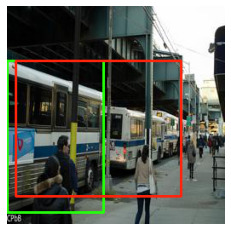

In [73]:
#Plotting an image along with ground truth and predicted annotations
plot_image(test_dataset,1828,model1,device)

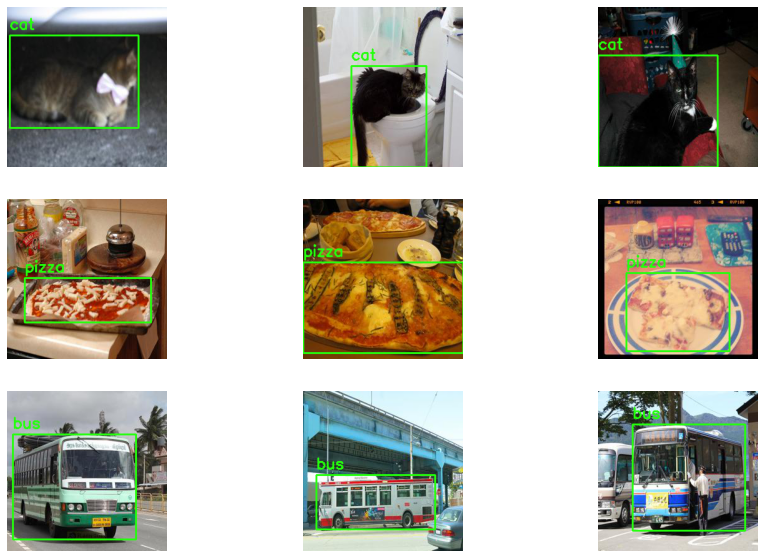

In [81]:
#Plotting the 3 images each of the 3 classes along with ground truth annotation
fig = plt.figure(figsize = (15,10))

ax11 = fig.add_subplot(3,3,1)
ax12 = fig.add_subplot(3,3,2)
ax13 = fig.add_subplot(3,3,3)

ax11.axis('off')
ax12.axis('off')
ax13.axis('off')

ax11.imshow(plot_image_ground(test_dataset,4))
ax12.imshow(plot_image_ground(test_dataset,2))
ax13.imshow(plot_image_ground(test_dataset,3))

ax21 = fig.add_subplot(3,3,4)
ax22 = fig.add_subplot(3,3,5)
ax23 = fig.add_subplot(3,3,6)

ax21.axis('off')
ax22.axis('off')
ax23.axis('off')

ax21.imshow(plot_image_ground(test_dataset,801))
ax22.imshow(plot_image_ground(test_dataset,800))
ax23.imshow(plot_image_ground(test_dataset,803))

ax31 = fig.add_subplot(3,3,7)
ax32 = fig.add_subplot(3,3,8)
ax33 = fig.add_subplot(3,3,9)

ax31.axis('off')
ax32.axis('off')
ax33.axis('off')

ax31.imshow(plot_image_ground(test_dataset,1899))
ax32.imshow(plot_image_ground(test_dataset,1902))
ax33.imshow(plot_image_ground(test_dataset,1903))

